In [1]:
import networkx as nx
import numpy as np
import pickle
import os
from env.utils import *
import matplotlib.pyplot as plt

In [2]:
def graph_dag_structure(v,
                      alpha,
                      seed,
                      save_path = None,
                      visualize = False):
    np.random.seed(seed)

    height_mean = np.sqrt(v) / alpha
    height = int(np.ceil(np.random.uniform(0, 2 * height_mean)))

    width_mean = alpha * np.sqrt(v)
    widths = []

    for i in range(height):
        widths.append(int(np.ceil(np.random.uniform(0, 2 * width_mean))))

    total_operator = sum(widths)

    G = nx.DiGraph()
    G.add_node(0)
    G.add_node(total_operator + 1)
    cnt = 1
    nodes = [[] for i in range(height + 2)]
    nodes[0].append(0)
    for i in range(height):
        for j in range(widths[i]):
            G.add_node(cnt)
            if i == 0:
                G.add_edge(0, cnt)
                nodes[i + 1].append(cnt)
            else:
                start_idx_last_layer = sum(widths[:i - 1]) + 1
                end_idx_last_layer = start_idx_last_layer + widths[i - 1] - 1
                nodes[i + 1].append(cnt)
                for node in range(start_idx_last_layer, end_idx_last_layer + 1):
                    p = np.random.binomial(1, 0.8)
                    if p:
                        G.add_edge(node, cnt)
            cnt += 1

    nodes[-1].append(total_operator + 1)
    end_start_idx = sum(widths[:-1])
    for i in range(widths[-1]):
        node = end_start_idx + i
        G.add_edge(node, total_operator + 1)

    # Valid checking, if any node in the middle is not connected
    # with any node in the following layer, randomly connect
    for i, layer in enumerate(nodes):
        for node in layer:
            if i != len(nodes) - 1:
                if G.out_degree(node) == 0:
                    choice = np.random.choice(nodes[i + 1])
                    G.add_edge(node, choice)

    for i, layer in enumerate(nodes):
        for node in layer:
            if i != 0:
                if G.in_degree(node) == 0:
                    choice = np.random.choice(nodes[i - 1])
                    G.add_edge(choice, node)

    if visualize:
        visualize_dag(G, widths, height)
    if save_path:
        graph_path = os.path.join(save_path,"dag_structure_v_{}_seed_{}_alpha_{}.pkl".format(v,seed, alpha))
        params_path = os.path.join(save_path, "dag_params_{}_seed_{}_alpha_{}.pkl".format(v, seed,alpha))
        params = {"widths": widths,
                  "height": height}
        save_dag(graph_path, G)
        to_pickle(params_path, params)
    return G

In [3]:
v = [20,40,60,80,100]
ccr = [0.1,0.5,1.0, 5.0, 10.0]
alpha = [0.5, 1.0, 2.0]
beta = [0.1, 0.25, 0.5, 0.75, 1.0]

for tv in v:
    for talpha in alpha:
        for seed in range(20):
            path = os.path.join("./data", "dag_structure_v_{}".format(tv))
            if not os.path.exists(path):
                os.makedirs(path)
            graph_dag_structure(tv, talpha, seed = seed, save_path = path)

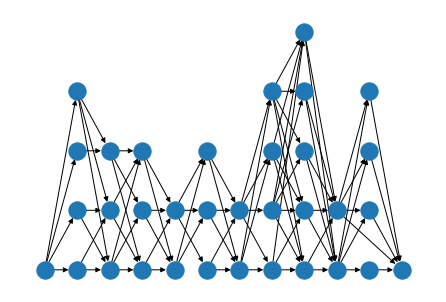

In [4]:
G = load_dag(os.path.join("./data", "dag_structure_v_20", "dag_structure_v_{}_seed_{}_alpha_{}.pkl".format(20,0,0.5)))
widths, height = load_dag_params(os.path.join("./data", "dag_structure_v_20","dag_params_{}_seed_{}_alpha_{}.pkl".format(20,0,0.5)))
visualize_dag(G,widths, height)

[4, 3, 3, 2, 3, 2, 4, 5, 2, 4]

In [69]:
def generate_weights_for_heterogeneous_devices(graph_path,
                        params_path,
                        alpha,
                        v,
                        ccr,
                        seed,
                        beta,
                        n_devices,
                        avg_comm = 1000,
                        avg_speed= 3,
                        avg_bw= 200,
                        avg_delay= 10,
                        save_path = None):
    np.random.seed(seed)

    G = load_dag(graph_path)
    widths, height = load_dag_params(params_path)

    avg_comm = np.random.normal(loc=avg_comm, scale=avg_comm / 3)
    avg_comp = avg_comm / ccr

    # Copmutation cost for each dag node on each device
    # Structure: list[list[list]]
    comps = [[] for i in range(height)]
    
    for i in range(height):
        for j in range(widths[i]):
            node_mean = np.random.uniform(0, 2 * avg_comp)
            tmp = []
            for device in range(n_devices):
                tmp.append(np.random.uniform(node_mean*(1-beta/2), node_mean*(1+beta/2)))
            comps[i].append(tmp)
    
    # Communication cost for each dag edge
    # Structure: dict, key: edge -> cost
    comms = {}
    for edge in G.edges:
        comms[edge] = np.random.uniform(0, 2 * avg_comm)
        
    # Delay for each device
    delay = np.random.uniform(0, 2 * avg_delay, n_devices)
    
    # bw for each device
    bw = np.random.uniform(0, 2 * avg_bw, n_devices)
    
    # speed for each device
    speed = np.random.uniform(0, 2 * avg_speed, n_devices)
    
    # Computational amount for each dag node.
    compute = [[] for i in range(height)]
    for i in range(height):
        for j in range(widths[i]):
            accum_compute = 0
            for k in range(n_devices):
                accum_compute += comps[i][j][k] * speed[k]
            avg_compute = accum_compute / n_devices
            compute[i].append(avg_compute)
            assert(compute[i][j] > 0, "Compute should be large than 0")
    
    # Communicational bytes for each dag link
    byte = {}
    for edge in G.edges:
        byte[edge] = (comms[edge] - avg_delay) * avg_bw
        if byte[edge] < 0:
            byte[edge] = 1
        assert(byte[edge] > 0), "Bytes should be large than 0"    

        
    if save_path:
        weight_path = os.path.join(save_path, "weights_heterogeneous_v_{}_seed_{}_alpha_{}_ccr_{}_beta_{}_ndevices_{}.pkl".format(v, seed, alpha, ccr, beta,n_devices))
        res = {"comps": comps,
               "comms": comms,
               "delay": delay,
               "bw": bw,
               "speed": speed,
               "compute": compute,
               "byte": byte}
        to_pickle(weight_path, res)      
#     return comps, comms

<>:58: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:58: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_1645/4038811929.py:58: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(compute[i][j] > 0, "Compute should be large than 0")


In [70]:
tv = 20
tccr = 0.1
talpha = 0.5
tbeta = 0.1
n_device = 10
seed = 0

graph_path = os.path.join("./data", "dag_structure_v_{}".format(tv), "dag_structure_v_{}_seed_{}_alpha_{}.pkl".format(tv,seed, talpha))
params_path = os.path.join("./data", "dag_structure_v_{}".format(tv), "dag_params_{}_seed_{}_alpha_{}.pkl".format(tv, seed,talpha))
weight_path = os.path.join("./data", "weights_v_{}".format(tv), "weights_heterogeneous_v_{}_seed_{}_alpha_{}_ccr_{}_beta_{}_ndevices_{}.pkl".format(tv, seed, talpha, tccr, tbeta,n_device))


generate_weights_for_heterogeneous_devices(graph_path,
                        params_path,
                        talpha,
                        tv,
                        tccr,
                        seed,
                        tbeta,
                        n_device,
                        avg_comm = 1000,
                        avg_speed= 3,
                        avg_bw= 200,
                        avg_delay= 10,
                        save_path = None)


In [66]:
v = [20,40,60,80,100]
ccr = [0.1,0.5,1.0, 5.0, 10.0]
alpha = [0.5, 1.0, 2.0]
beta = [0.1, 0.25, 0.5, 0.75, 1.0]
n_devices = [10,20,30]

for tv in v:
    for talpha in alpha:
        for tccr in ccr:
            for tbeta in beta:
                for n_device in n_devices:
            
                    for seed in range(10):
                        graph_path = os.path.join("./data", "dag_structure_v_{}".format(tv), "dag_structure_v_{}_seed_{}_alpha_{}.pkl".format(tv,seed, talpha))
                        param_path = os.path.join("./data", "dag_structure_v_{}".format(tv), "dag_params_{}_seed_{}_alpha_{}.pkl".format(tv, seed,talpha))

                        path = os.path.join("./data", "weights_v_{}".format(tv))

                        if not os.path.exists(path):
                            os.makedirs(path)

                        generate_weights_for_heterogeneous_devices(graph_path,
                                                                   param_path,
                                                                   talpha,
                                                                   tv,
                                                                   tccr,
                                                                   seed,
                                                                   tbeta,
                                                                   n_device,
                                                                   save_path = path)
                        

In [71]:
tv = 20
tccr = 0.1
talpha = 0.5
tbeta = 0.1
n_device = 10
seed = 0

path = os.path.join("./data", "weights_v_{}".format(tv), "weights_heterogeneous_v_{}_seed_{}_alpha_{}_ccr_{}_beta_{}_ndevices_{}.pkl".format(tv, seed,talpha, tccr, tbeta,n_device))
def load_pickle(path):
    with open(path, 'rb') as handle:
        res = pickle.load(handle)
    return res

res = load_pickle(path)

In [72]:
res.keys()

dict_keys(['comps', 'comms', 'delay', 'bw', 'speed', 'compute', 'byte'])

In [82]:
v = [20,40,60,80,100]
ccr = [0.1,0.5,1.0, 5.0, 10.0]
alpha = [0.5, 1.0, 2.0]
beta = [0.1, 0.25, 0.5, 0.75, 1.0]
n_devices = [10,20,30]

# os.path.join("./data", "dag_structure_v_{}".format(tv))
# os.path.join(save_path,"dag_structure_v_{}_seed_{}_alpha_{}.pkl".format(v,seed, alpha))
# G = load_dag(os.path.join("./data", "dag_structure_v_20", "dag_structure_v_{}_seed_{}_alpha_{}.pkl".format(20,0,0.5)))
# widths, height = load_dag_params(os.path.join("./data", "dag_structure_v_20","dag_params_{}_seed_{}_alpha_{}.pkl".format(20,0,0.5)))
# graph_path = os.path.join("./data", "dag_structure_v_{}".format(tv), "dag_structure_v_{}_seed_{}_alpha_{}.pkl".format(tv,seed, talpha))
# param_path = os.path.join("./data", "dag_structure_v_{}".format(tv), "dag_params_{}_seed_{}_alpha_{}.pkl".format(tv, seed,talpha))
# "weights_heterogeneous_v_{}_seed_{}_ccr_{}_beta_{}_ndevices_{}.pkl".format(v, seed, ccr, beta,n_devices)


In [83]:
def load_training_instance_for(v, seed, alpha, ccr, beta, n_devices):
    graph_path = os.path.join("./data", "dag_structure_v_{}".format(v), "dag_structure_v_{}_seed_{}_alpha_{}.pkl".format(v,seed, alpha))
    param_path = os.path.join("./data", "dag_structure_v_{}".format(v), "dag_params_{}_seed_{}_alpha_{}.pkl".format(v, seed,alpha))
    weight_path = os.path.join("./data", "weights_v_{}".format(v), "weights_heterogeneous_v_{}_seed_{}_alpha_{}_ccr_{}_beta_{}_ndevices_{}.pkl".format(v, seed, alpha, ccr, beta,n_devices))
        
    G = load_dag(graph_path)
    widths, height = load_dag_params(param_path)
    
    weights = load_pickle(weight_path)
    delay, bw, speed, compute, byte = weights['delay'], weights['bw'], weights['speed'], weights['compute'], weights['byte']
    
    cnt = 1

    comp = weights["comps"]
    
    for i in range(height):
        for j in range(widths[i]):
            G.nodes[cnt]["compute"] = compute[i][j]
            cnt += 1
    
    total_operator = sum(widths)
    G.nodes[0]["compute"] = 0
    G.nodes[total_operator+1]["compute"] = 0
    
    for e in G.edges:
        G.edges[e]['bytes'] = byte[e]
    
    return delay, bw, speed, G
    

In [84]:
delay, bw, speed, G = load_training_instance_for(tv, seed, talpha, tccr, tbeta, n_device)

In [4]:

def load_graph_with_weights(graph_path, weight_path, params_path):
    G  = load_dag(graph_path)
    comms, comps = load_weights(weight_path)
    widths, height = load_dag_params(params_path)

    cnt = 1
    for i in range(height):
        for j in range(widths[i]):
            G.nodes[cnt]['compute'] = comps[i][j]
            cnt += 1

    for e in G.edges:
        G.edges[e]['bytes'] = comms[e]

    return G

array([325.98659175, 394.19657106, 387.58868187, 361.97933822,
       118.62250603, 396.80449737,  99.76801642,  42.36246195,
       380.38104442,  93.36810219])